In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
import cv2
import h5py
from tqdm.notebook import trange, tqdm

import os
from os.path import join
import glob
import re


In [108]:
def get_data(img_path, label_path, h5_name):
    '''
    Function to get the images and labels.
    
    Parameters:
    img_path: Path where the images are stored.
    label_path: Text file path where the data info is stored.
    h5_name: h5 file name to save the images and labels.
    
    '''
    
    
    # Get all the image file names
    img_grab = glob.glob(join(img_path, '*'))
    
    # Open the label file in read more
    label_grab = open(label_path, "r")
    
    # Create a label dictionary
    meta = open(label_path, "r").readlines()

    patient_id = []
    file_ids = []
    labels = []
    sources = []

    for line in meta:
        parts = line.split(' ')
        parts = [part.strip('\n') for part in parts]
        file_id = parts[1].rsplit('.', 1)[0]

        patient_id.append(parts[0])
        file_ids.append(file_id)
        labels.append(parts[2])
        sources.append(parts[3])

    cols=['patient_id', 'file_id', 'labels', 'sources']
    label_df = pd.DataFrame(list(zip(patient_id, file_ids, labels, sources)), columns = cols)

    imgs = []
    img_lbls = []
    HEIGHT = 128
    WIDTH = 128
    CHANNEL = 1

    for i, img in enumerate(tqdm(img_grab, leave=False, desc='Getting images and labels: ', ncols='100%')):
        img_id = img.split('\\')[-1].rsplit('.', 1)[0]
        read_img = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2GRAY)
        read_img = cv2.resize(read_img, dsize=(HEIGHT, WIDTH), interpolation=cv2.INTER_CUBIC)
        imgs.append(read_img)
        get_label = label_df.loc[label_df['file_id'] == img_id]['labels'].values[0]   
        img_lbls.append(get_label)
        
    imgs = np.array(imgs)
    
    with h5py.File(h5_name, 'w') as hf:
        Xset = hf.create_dataset(name='imgs', data=imgs, compression="gzip", compression_opts=9)
        yset = hf.create_dataset(name='labels', data = np.array(img_lbls, dtype=object),
                                 compression='gzip', compression_opts=1, dtype=h5py.special_dtype(vlen=str))
        
    hf.close()
    
    return imgs, img_lbls

In [3]:
# train images and label path
train_img_grab = './data/train'
train_label_grab = 'COVID-Net/train_split.txt'

# test images and label path
test_img_grab = './data/test'
test_label_grab = 'COVID-Net/test_split.txt'

In [104]:
###################################################
# Run this only if you have the h5 files
# and don't want to process all the images again.
# Otherwise run the two cells below.
# The bottom two cells will generate HDF5 (.h5)
# format files which is compressed form of data
###################################################

with h5py.File('data_train.h5', 'r') as hf:
    test_imgs = np.array(hf['imgs'])
    test_labels = np.array(hf['labels'])


with h5py.File('data_test.h5', 'r') as hf:
    test_imgs = np.array(hf['imgs'])
    test_labels = np.array(hf['labels'])

In [109]:
train_imgs, train_labels = get_data(train_img_grab, train_label_grab, 'data_train.h5')

In [110]:
test_imgs, test_labels = get_data(test_img_grab, test_label_grab, 'data_test.h5')

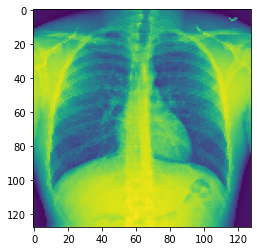

In [111]:
plb.imshow(test_imgs[0])

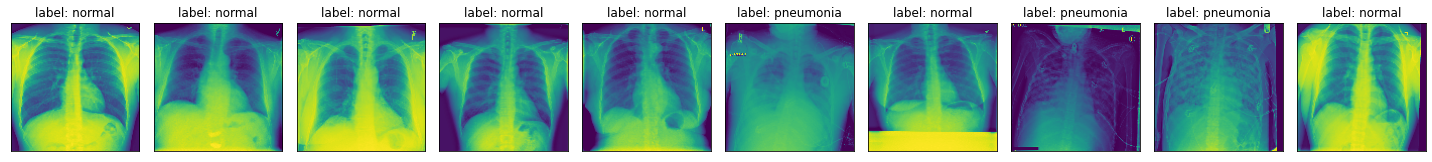

In [112]:
fig = plt.figure(figsize=(20,15))
for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    ax.imshow(test_imgs[i])
    ax.set_title('label: '+str(test_labels[i]))

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
fig.tight_layout()
plt.show()